# $\epsilon$ Indi

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
#repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
scripts_path = "../../scripts" #os.path.join(repo_root, 'scripts')
sys.path.append(scripts_path)

import prior_funcs, utils
from pitchfuncs_ultra_pca_v2 import emulator
from pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface



import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2025-01-30 22:25:47.200483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 22:25:47.211052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 22:25:47.214282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 22:25:47.750524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import pitchfork

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork_path = "../../pitchfork/"

pitchfork = emulator(pitchfork_name, file_path=pitchfork_path)


with open(pitchfork_path+ pitchfork_name+'.pkl', 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

In [ ]:
import scipy
import numpy as np
from scipy import constants
from scipy import stats
import astropy.constants

def calc_L(Teff, radius):
    return (4*np.pi*((radius*astropy.constants.R_sun)**2)*constants.sigma*(Teff**4))/astropy.constants.L_sun

calc_L()

In [3]:
#parameters for star, [value,unc], NaN for not found/published
#[1] - Lundkvist 2024, https://arxiv.org/pdf/2403.04509
#[2] - Campante 2024 https://www.aanda.org/articles/aa/pdf/2024/03/aa49197-24.pdf

star_name = 'eIndi'

star_dict={}

star_dict['initial_mass']=[0.782, 0.023] #1
star_dict['initial_Zinit']= [0.02,0] 
star_dict['initial_Yinit']= [0.28,0] 
star_dict['initial_MLT']= [2,0]
star_dict['star_age']=[3, 0] 

star_dict['calc_effective_T']=[4700, 65]
star_dict['radius']= [0.711, 0.005]
star_dict['luminosity']= [0.21, 0.02] 
star_dict['star_feh']=[-0.17, 0.05] #2

star_dict['nu_0_21']= [4518.59, 1.15] #2
star_dict['nu_0_22']= [4720.55, 0.92] #2
star_dict['nu_0_23']= [4919.93, 0.87] #2
star_dict['nu_0_24']= [5121.61, 0.51] #2
star_dict['nu_0_25']= [5322.46, 0.91] #2
star_dict['nu_0_26']= [5525.24, 1.28] #2
star_dict['nu_0_27']= [5726.30, 1.13] #2


star_dict['dnu'] =[201.25, 0.16] #2
star_dict['nu_max'] = [5265, 110] #1

with open(f'{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [0.782, 0.023],
 'initial_Zinit': [0.02, 0],
 'initial_Yinit': [0.28, 0],
 'initial_MLT': [2, 0],
 'star_age': [3, 0],
 'calc_effective_T': [4700, 65],
 'radius': [0.711, 0.005],
 'luminosity': [0.21, 0.02],
 'star_feh': [-0.17, 0.05],
 'nu_0_21': [4518.59, 1.15],
 'nu_0_22': [4720.55, 0.92],
 'nu_0_23': [4919.93, 0.87],
 'nu_0_24': [5121.61, 0.51],
 'nu_0_25': [5322.46, 0.91],
 'nu_0_26': [5525.24, 1.28],
 'nu_0_27': [5726.3, 1.13],
 'dnu': [201.25, 0.16],
 'nu_max': [5265, 110]}

## define priors

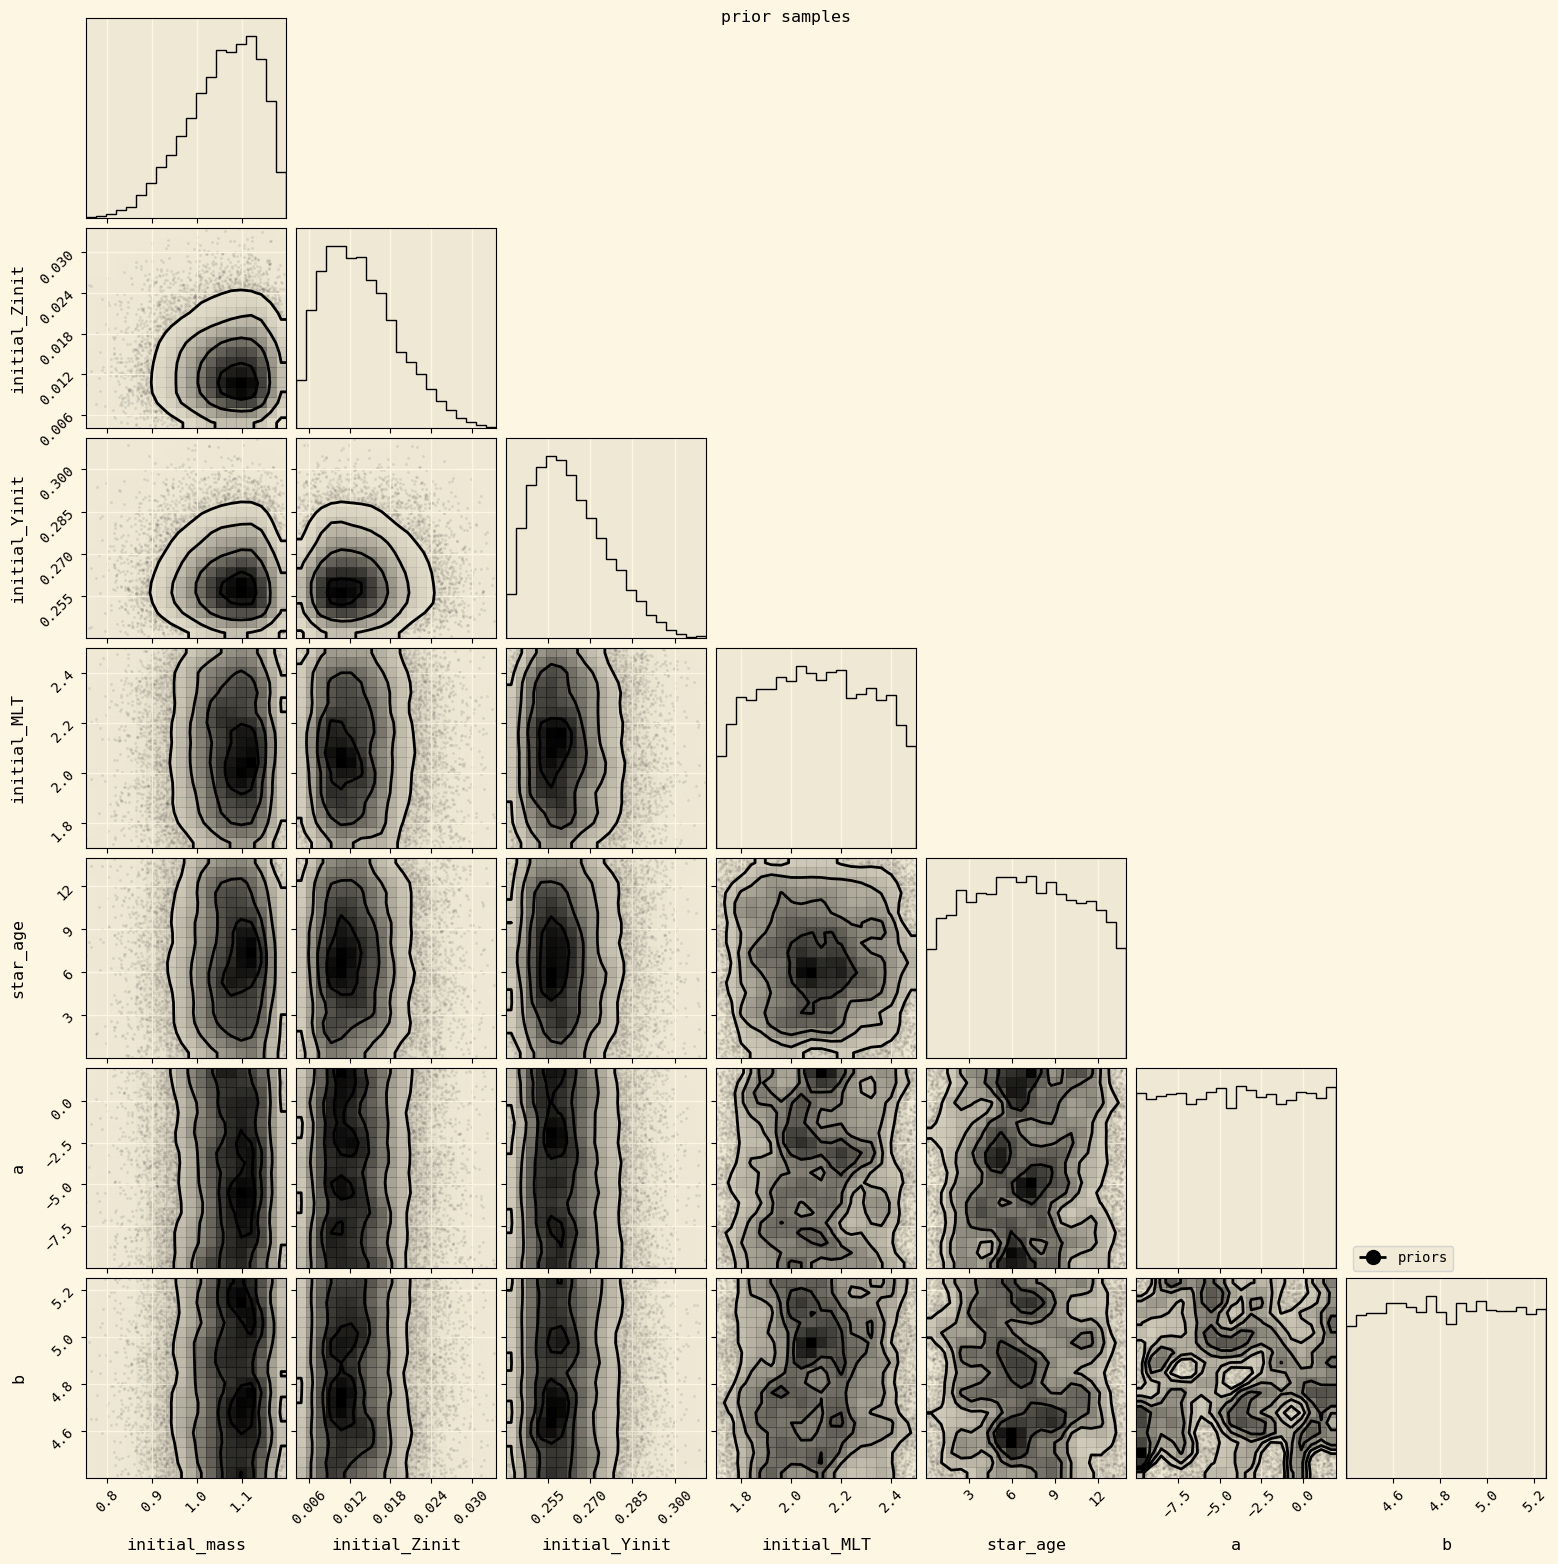

In [4]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.7, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [6]:
import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

star_json = f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
with open(pitchfork_path+ "/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 5*kernels.ExpSquared(scale=3*dnu) ##### changed to 20 dnu instead of 5, 5 muHz too

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

ndraw_min=2**16 #2**16
ndraw_max=2**19
min_num_live_points = 256

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = ultra_ns_vector_surface(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.5)#, max_ncalls=5e6)
with open('samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()


|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|          0.782 |            0.02 |            0.28 |             2 |          3 |


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


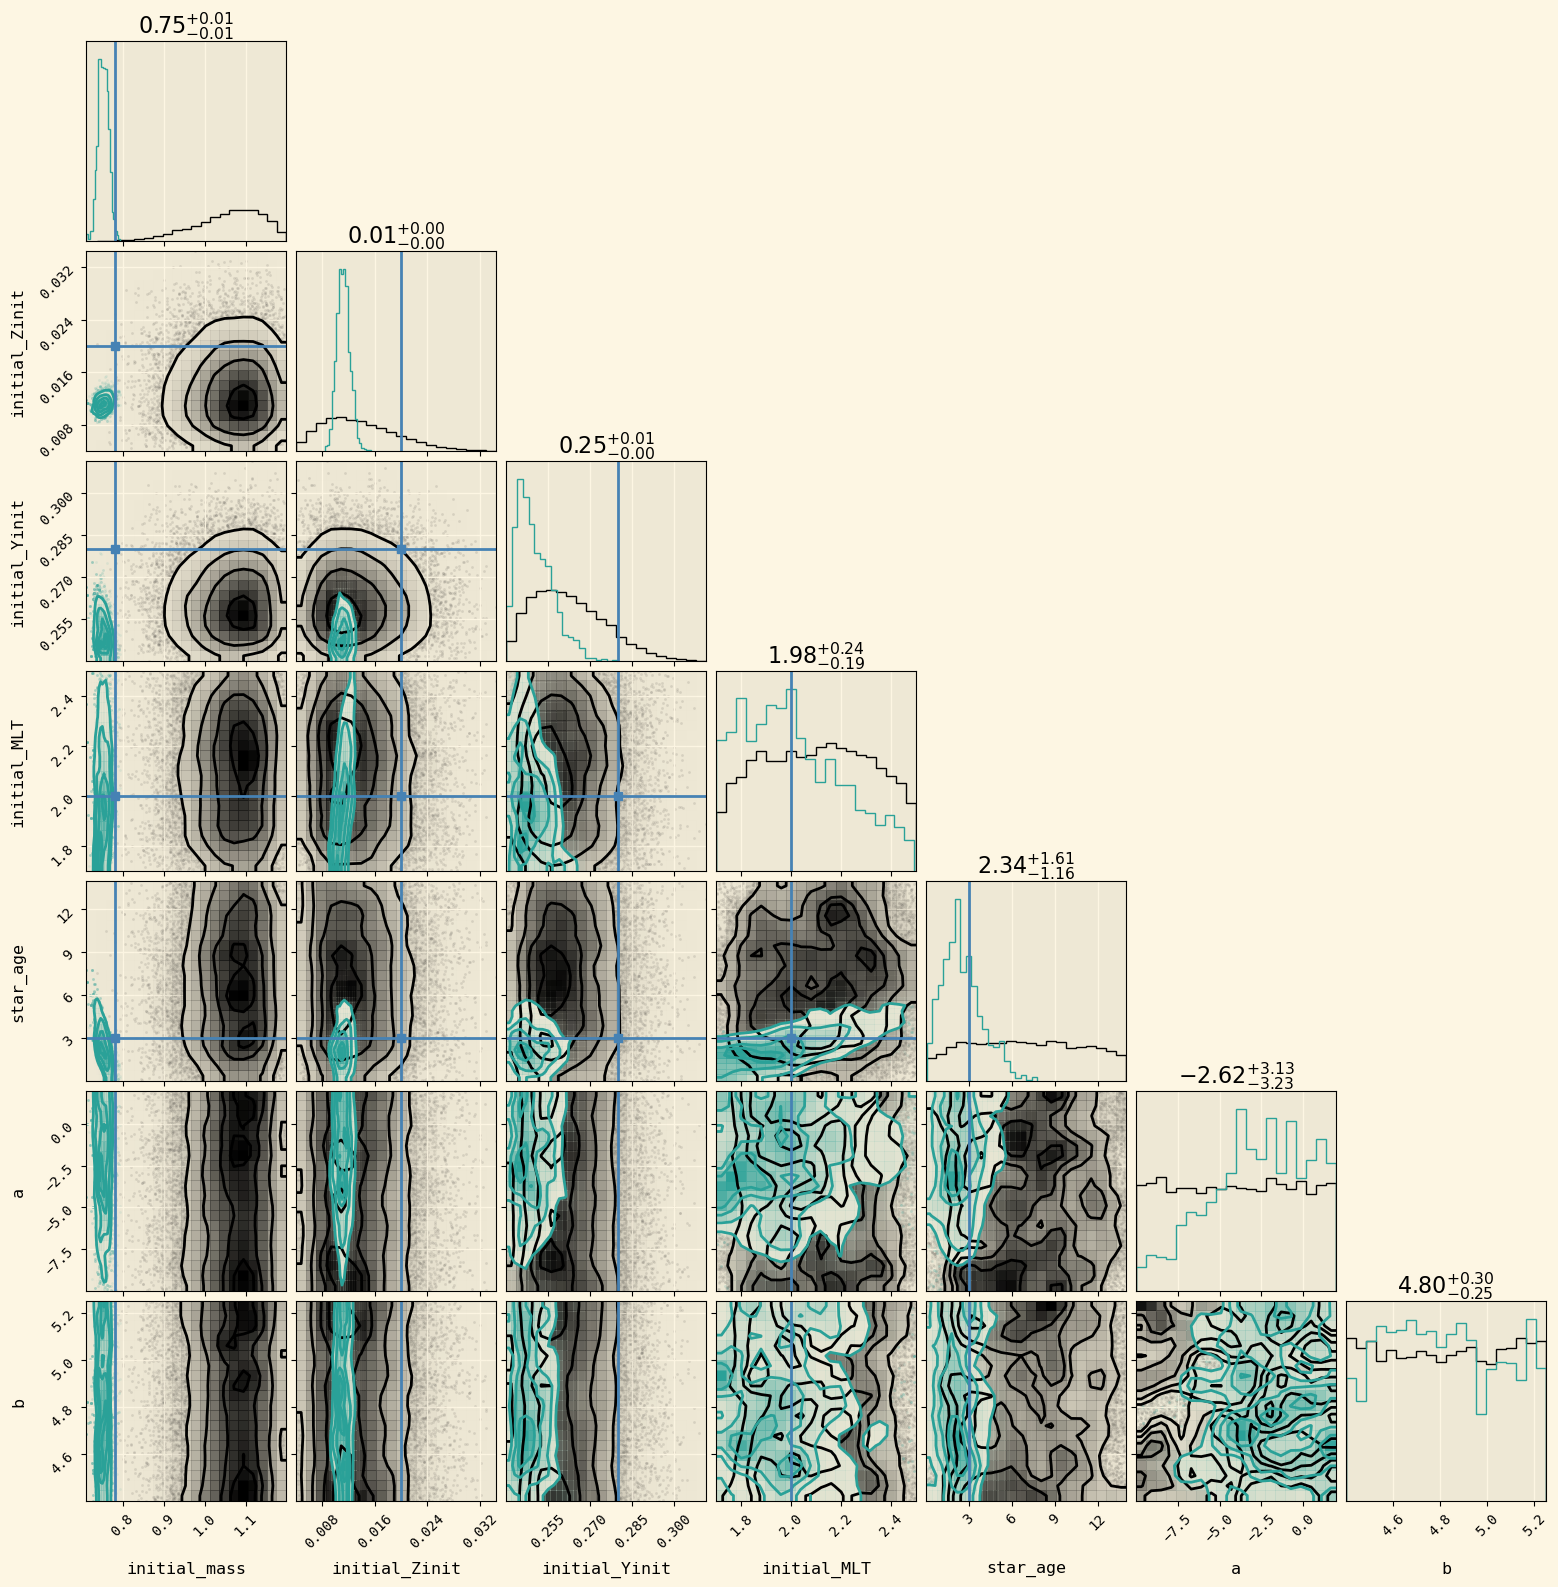

In [10]:
def inspect_star(path):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.7, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    

    star_json = f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open('samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)

    
    corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);

    plt.show()

    
inspect_star(star_name)

0       0.694044
1       0.691430
2       0.698713
3       0.703142
4       0.694136
          ...   
4670    0.693974
4671    0.696245
4672    0.687258
4673    0.697593
4674    0.698568
Name: radius, Length: 4675, dtype: float64


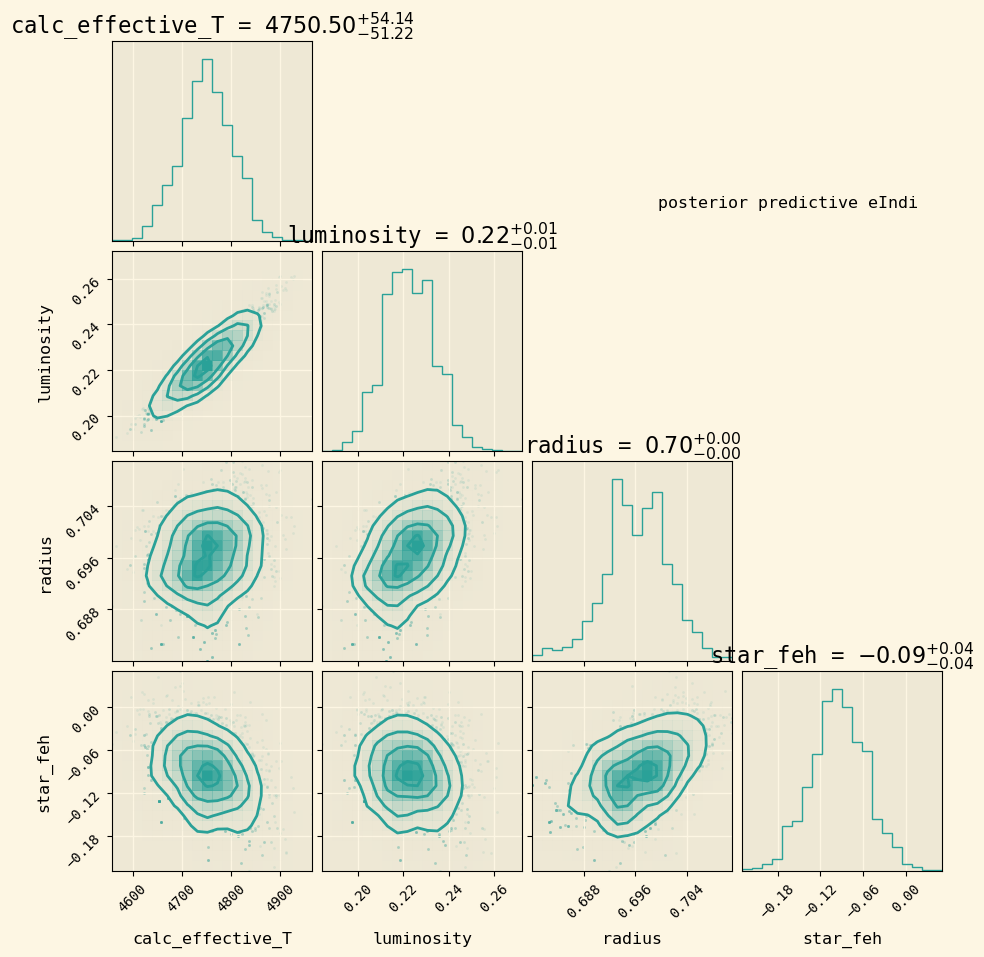

nu_0_21    4520.935652
nu_0_22    4721.909416
nu_0_23    4922.784314
nu_0_24    5123.820508
nu_0_25    5325.215686
nu_0_26    5527.160202
dtype: float64
[4518.59]
[4720.55]
[4919.93]
[5121.61]
[5322.46]
[5525.24]


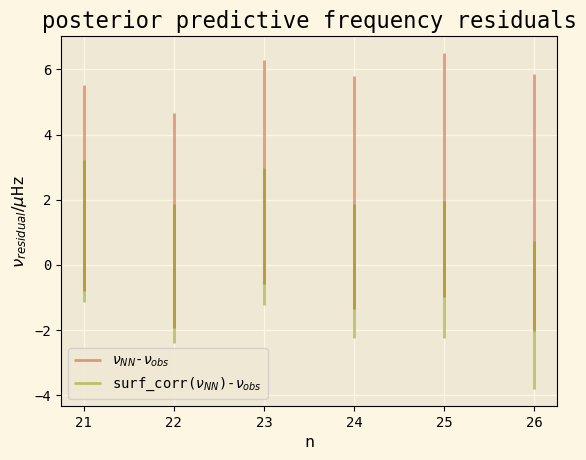

FileNotFoundError: stars/eIndi/power.pow not found.

In [9]:
def posterior_pred(pitchfork, star_name):

    with open('samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    pred_freqs = preds_df[[f"nu_0_{i}" for i in range(n_min, n_max)]]
    print(np.mean(pred_freqs, axis=0))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    for n in range(n_min, n_max):
        n_samples = pred_freqs[f"nu_0_{n}"].values
        observed_freqs = star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1)[f"nu_0_{n}"].values
        print(observed_freqs)

        n_samples_residual = n_samples - np.full(len(n_samples),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std
        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4], label=r'$\nu_{NN}$-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4],alpha=.5)


        
        n_samples_corr = surf_corr(n_samples, nu_max, a_samples, b_samples)
        
        n_samples_residual = n_samples_corr - np.full(len(n_samples_corr),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std

        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2], label=r'surf_corr($\nu_{NN}$)-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2],alpha=.5)
        ###

        ### keep for points
        #plt.scatter(np.full(len(n_samples_residual), n), n_samples_residual,c=colors[2], alpha=0.002)
    
        ###

    plt.legend()
    plt.xlabel('n')
    plt.ylabel(r'$\nu_{residual}/\mu$Hz')
    plt.title('posterior predictive frequency residuals')
    plt.show()

    from echelle import plot_echelle

    spectrum = np.loadtxt(f'stars/{star_name}/power.pow')
    freq = spectrum[:,0]
    power = spectrum[:,1]
    
    ax = plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=1500, fmax=3500, interpolation='bicubic', smooth=True)

    mean_preds = np.mean(pred_freqs, axis=0)
    ax.scatter(mean_preds%dnu, mean_preds)

    corrected = surf_corr(mean_preds, nu_max, np.mean(a_samples), np.mean(b_samples))

    ax.scatter(corrected%dnu, corrected)
    
    plt.grid(visible=None)

posterior_pred(pitchfork, star_name)